In [1]:
from pylab import *
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import h5py
import ringdown
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy
sns.set_context('notebook')
sns.set_palette('colorblind')

In [2]:
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

In [3]:
!openssl md5 H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
!openssl md5 L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853


# Data Processing Steps:
1)  Read the strains
2)  Plot the strains
3)  Plot the PSDs
4)  Study the signal decimation of the different QNMs
5)  Defining analysis duration using longest lasting QNM
6)  Defining model and conditioning the data before running fit
7)  Whitened data segments
8)  Updating priors
9)  Running Fit
10) Data Summary

In [4]:
#1) Read the strains
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain
    
h_raw_strain = read_strain('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'H1')
l_raw_strain = read_strain('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'L1')

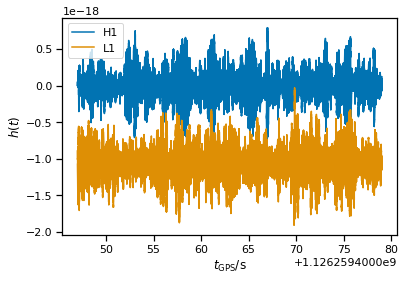

In [5]:
#2) Plot the strains
h_raw_strain.plot(label=h_raw_strain.ifo)
l_raw_strain.plot(label=l_raw_strain.ifo)
xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
ylabel(r'$h(t)$');
legend(loc='best');

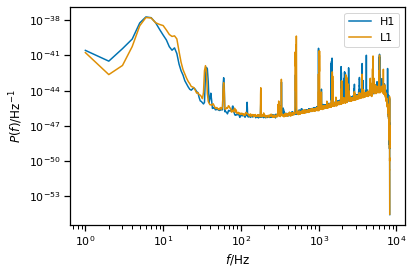

In [6]:
#3) Plot the PSDs
h_raw_strain.get_psd(nperseg=int(h_raw_strain.fsamp)).iloc[1:].plot(label=h_raw_strain.ifo)
l_raw_strain.get_psd(nperseg=int(l_raw_strain.fsamp)).iloc[1:].plot(label=l_raw_strain.ifo)
xlabel(r'$f / \mathrm{Hz}$');
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
xscale('log');
yscale('log');
legend(loc='best');

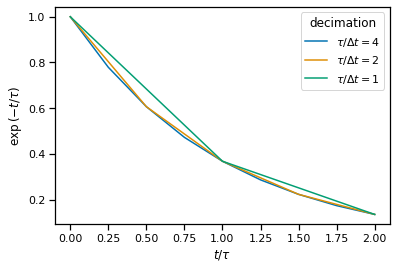

In [7]:
#4) Study the signal decimation of the different QNMs
x = linspace(0, 2, 9)
for i in [1, 2, 4]:
    plot(x[::i], exp(-x[::i]), label=r'$\tau / \Delta t = {:.0f}$'.format(4/i))
legend(title='decimation')
xlabel(r'$t / \tau$')
ylabel(r'$\exp\left( - t / \tau \right)$');

In [8]:
#5) Defining analysis duration using longest lasting QNM
M_est = 70.0
chi_est = 0.7

longest_tau = ringdown.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/ringdown.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

def next_pow_two(x):
    y = 1
    while y < x:
        y = y << 1
    return y

T = 10*longest_tau
srate = next_pow_two(2*highest_drate)

print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 708.4 Hz
The time constant of the first tone is: 4.3 ms
Segment of 42.7 ms at sample rate 2048


In [9]:
#6) Defining model and conditioning the data before running fit
fit = ringdown.Fit(model='mchi', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])  # use model='ftau' to fit damped sinusoids instead of +/x polarized GW modes
fit.add_data(h_raw_strain)
fit.add_data(l_raw_strain)
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=1/T)
np.random.seed(1234)

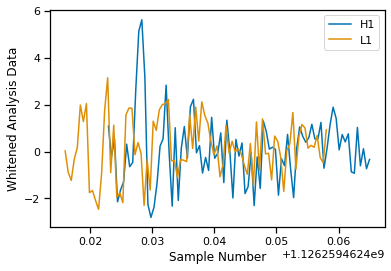

In [10]:
#7) Whitened data segments
fit.compute_acfs()
wd = fit.whiten(fit.analysis_data)
plot(wd['H1'], label='H1')
plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

In [11]:
fit.start_times

{'H1': 1126259462.423, 'L1': 1126259462.4160156}

In [12]:
print(fit.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max', 'flat_A', 'flat_A_ellip']


In [13]:
#8) Updating priors
fit.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, flat_A=True)

In [14]:
fit.prior_settings

{'A_scale': 5e-21,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'flat_A': True,
 'flat_A_ellip': 0}

In [15]:
#9) Running Fit
fit.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
INFO:pymc:NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


In [16]:
#10) Data Summary
az.summary(fit.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.000,0.000,0.000,0.000,0.000,0.000,735.0,1037.0,1.00
A[1],0.000,0.000,0.000,0.000,0.000,0.000,688.0,1106.0,1.00
M,72.351,9.367,54.804,87.471,0.350,0.259,801.0,728.0,1.01
chi,0.635,0.191,0.238,0.923,0.007,0.005,776.0,510.0,1.00
f[0],234.221,9.081,216.987,250.810,0.229,0.162,1634.0,1609.0,1.00
f[1],228.191,10.637,207.851,247.173,0.293,0.208,1376.0,1467.0,1.00
tau[0],0.005,0.001,0.003,0.006,0.000,0.000,810.0,688.0,1.00
tau[1],0.001,0.000,0.001,0.002,0.000,0.000,805.0,685.0,1.00


# Mass and dimensionless spin come as a 4x1000 arrays. 

In [17]:
print(fit.result.posterior.M)

<xarray.DataArray 'M' (chain: 4, draw: 1000)>
array([[78.1252343 , 89.66190127, 75.37711428, ..., 71.62563695,
        68.51031803, 79.83390786],
       [71.75834223, 74.53812315, 76.45775512, ..., 77.66664898,
        84.97599943, 81.03216696],
       [68.05789649, 63.83702738, 75.66967642, ..., 57.50680062,
        60.21369982, 64.54358468],
       [59.30350095, 56.31681256, 53.78623346, ..., 79.2430492 ,
        59.78739387, 98.19245275]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999


In [62]:
m = np.array(fit.result.posterior.M)
spin = np.array(fit.result.posterior.chi)
mass = np.array([])
a = np.array([])
for i in range(0,4):
    mass = np.append(mass,m[i])
    a = np.append(a,spin[i])

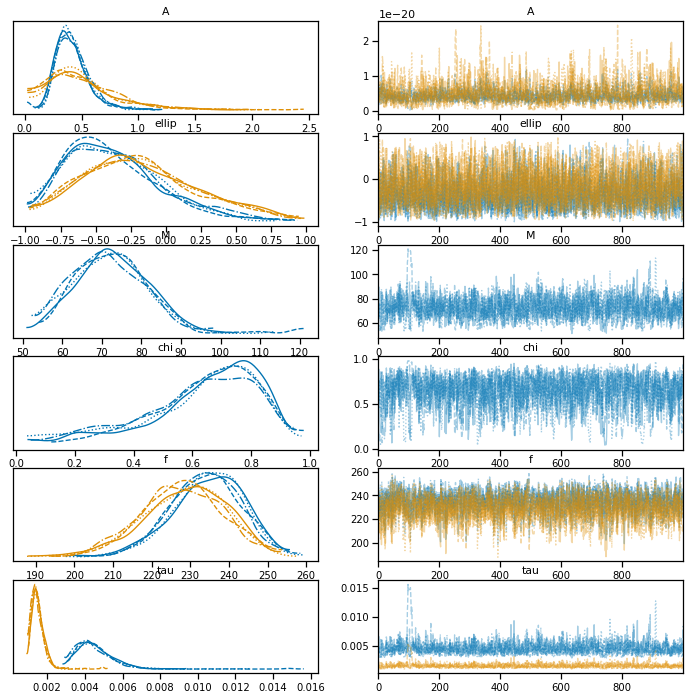

In [63]:
az.plot_trace(fit.result, var_names=['A', 'ellip', 'M', 'chi', 'f', 'tau'], compact=True);

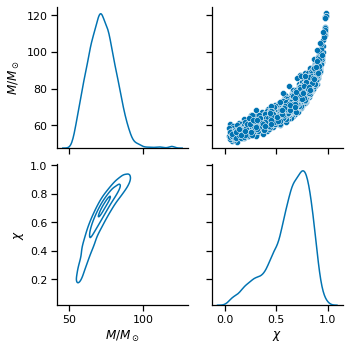

In [64]:
df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

# Computing final BH area

In [65]:
G = 6.67 * (10**(-11))
c = 9 * (10**9)
area = [0 for i in range(0,len(mass))]
for i in range(0,len(mass)): 
    temp = 8*np.pi*(((G*mass[i])/(c**2))**2)*(1+((1-(a[i]**2))**(1/2)))
    area[i] = temp
area_f = np.array(area)

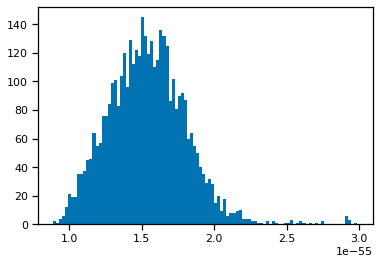

In [66]:
plt.hist(area_f,bins=100)
plt.show()

# Inspiral Data from PESummary to get initial area

In [67]:
ins = np.genfromtxt('/nasdata1/ashwin.girish/downsampled_posterior_samples_v1.0.0/GW150914_downsampled_posterior_samples.dat', dtype=None)
insp = np.genfromtxt('/nasdata1/ashwin.girish/downsampled_posterior_samples_v1.0.0/GW150914_downsampled_posterior_samples.dat', dtype=float)
print(shape(insp))

/tmp/ipykernel_45638/3345774408.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  ins = np.genfromtxt('/nasdata1/ashwin.girish/downsampled_posterior_samples_v1.0.0/GW150914_downsampled_posterior_samples.dat', dtype=None)


(50001, 113)


In [68]:
print(ins[0])
print(shape(ins[0]))

[b'chirp_mass' b'mass_ratio' b'a_1' b'a_2' b'tilt_1' b'tilt_2' b'phi_12'
 b'phi_jl' b'theta_jn' b'psi' b'azimuth' b'zenith' b'H1_time'
 b'recalib_H1_amplitude_0' b'recalib_H1_amplitude_1'
 b'recalib_H1_amplitude_2' b'recalib_H1_amplitude_3'
 b'recalib_H1_amplitude_4' b'recalib_H1_amplitude_5'
 b'recalib_H1_amplitude_6' b'recalib_H1_amplitude_7'
 b'recalib_H1_amplitude_8' b'recalib_H1_amplitude_9' b'recalib_H1_phase_0'
 b'recalib_H1_phase_1' b'recalib_H1_phase_2' b'recalib_H1_phase_3'
 b'recalib_H1_phase_4' b'recalib_H1_phase_5' b'recalib_H1_phase_6'
 b'recalib_H1_phase_7' b'recalib_H1_phase_8' b'recalib_H1_phase_9'
 b'recalib_L1_amplitude_0' b'recalib_L1_amplitude_1'
 b'recalib_L1_amplitude_2' b'recalib_L1_amplitude_3'
 b'recalib_L1_amplitude_4' b'recalib_L1_amplitude_5'
 b'recalib_L1_amplitude_6' b'recalib_L1_amplitude_7'
 b'recalib_L1_amplitude_8' b'recalib_L1_amplitude_9' b'recalib_L1_phase_0'
 b'recalib_L1_phase_1' b'recalib_L1_phase_2' b'recalib_L1_phase_3'
 b'recalib_L1_phase_4' 

# Collecting Initial source masses and angular momenta

In [69]:
mass1 = np.array([insp[i][-10] for i in range(1,50001)])
mass2 = np.array([insp[i][-9] for i in range(1,50001)])
a1 = np.array([insp[i][2] for i in range(1,50001)])
a2 = np.array([insp[i][3] for i in range(1,50001)])

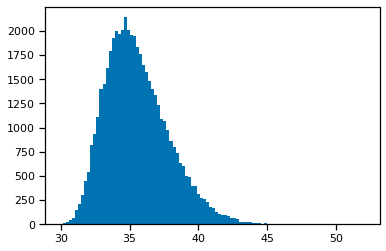

In [70]:
plt.hist(mass1,bins=100)
plt.show()

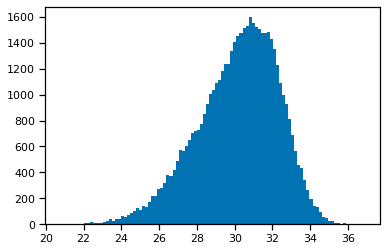

In [71]:
plt.hist(mass2,bins=100)
plt.show()

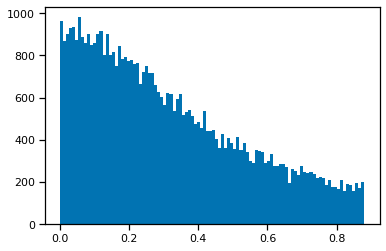

In [72]:
plt.hist(a1,bins=100)
plt.show()

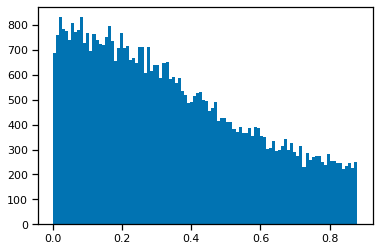

In [73]:
plt.hist(a2,bins=100)
plt.show()

# Calculating Initial Areas, and total initial area

In [106]:
area1 = np.array([8*np.pi*(((G*mass1[i])/(c**2))**2)*(1+((1-(a1[i]**2))**(1/2))) for i in range(0,50000)])
area2 = np.array([8*np.pi*(((G*mass2[i])/(c**2))**2)*(1+((1-(a2[i]**2))**(1/2))) for i in range(0,50000)])

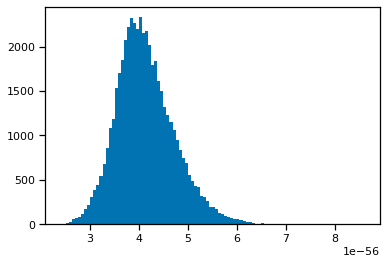

In [107]:
plt.hist(area1,bins=100)
plt.show()

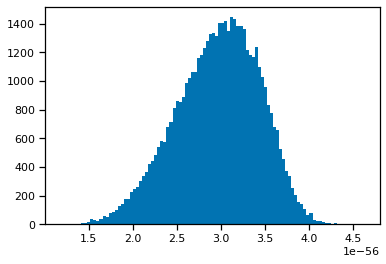

In [108]:
plt.hist(area2,bins=100)
plt.show()

# Total Initial Area

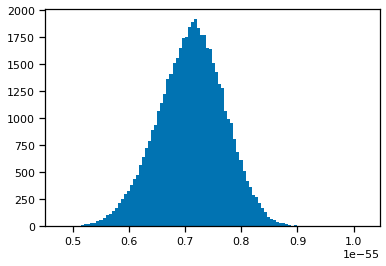

In [109]:
area_i = np.array([(area1[i] + area2[i]) for i in range(len(area1))])
plt.hist(area_i,bins=100)
plt.show()

# Method 1: Mean_final_area - init_area_array

In [110]:
area_mean = 0
n = 0
for ar in area_f:
    area_mean = area_mean+ar
    n+=1
area_mean = area_mean/n
print(area_mean)

1.5376496219492043e-55


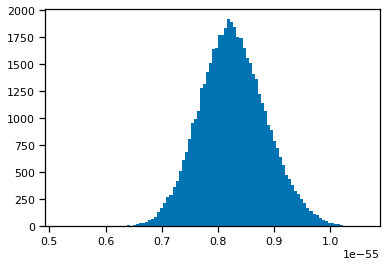

In [111]:
delta_A = np.array([(area_mean - i) for i in area_i])
plt.hist(delta_A,bins=100)
plt.show()

# Method 2: Using first 1000 elements only, and calculating element-by-element differences

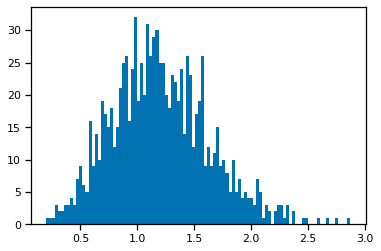

In [112]:
dA = np.array([area_f[i] - area_i[i] for i in range(0,len(area_f))])
da = np.array([dA[i]/area_i[i] for i in range(0,1000)])
plt.hist(da,bins=100)
plt.show()

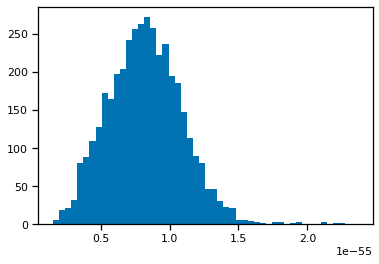

In [113]:
plt.hist(dA,bins=50)
plt.show()

# Method 3: Finding Convolution of Final and Initial Areas : Wrong method because pdfs have to be convolved, not areas

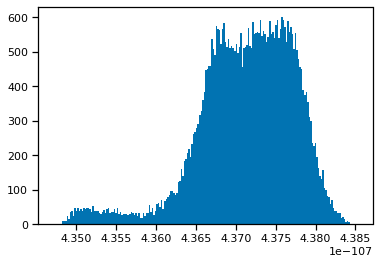

In [114]:
del_area = sig.oaconvolve(area_f,area_i,mode='valid')
plt.hist(del_area,bins=200)
plt.show()

# Importing a library called distfit to find PDF from data

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 1.13451e+110] [loc=0.000 scale=0.000]
[distfit] >[expon     ] [0.00 sec] [RSS: 3.36314e+112] [loc=0.000 scale=0.000]
[distfit] >[pareto    ] [0.04 sec] [RSS: inf] [loc=-0.000 scale=0.000]
[distfit] >[dweibull  ] [1.11 sec] [RSS: 7.56584e+110] [loc=0.000 scale=0.000]
[distfit] >[t         ] [3.16 sec] [RSS: 4.41149e+112] [loc=-0.000 scale=0.000]
[distfit] >[genextreme] [2.29 sec] [RSS: 4.41149e+112] [loc=-0.000 scale=0.000]
[distfit] >[gamma     ] [1.30 sec] [RSS: 2.34071e+110] [loc=-0.000 scale=0.000]
[distfit] >[lognorm   ] [1.57 sec] [RSS: 4.41149e+112] [loc=0.000 scale=0.000]
[distfit] >[beta      ] [2.44 sec] [RSS: 2.52772e+109] [loc=-0.000 scale=0.000]
[distfit] >[uniform   ] [0.00 sec] [RSS: 2.70665e+112] [loc=0.000 scale=0.000]
[distfit] >[loggamma  ] [0.33 sec] [RSS: 2.19506e+109] [loc=-0.000 scale=0.000]
[distfit] >Compute confidence interval [parametric]
[distfit] >predict..
[distfit] >Multiple t

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nloggamma\nRSS(c=42.4277, loc=-7.20125e-56, scale=3.82995e-56)'}, xlabel='Values', ylabel='Frequency'>)

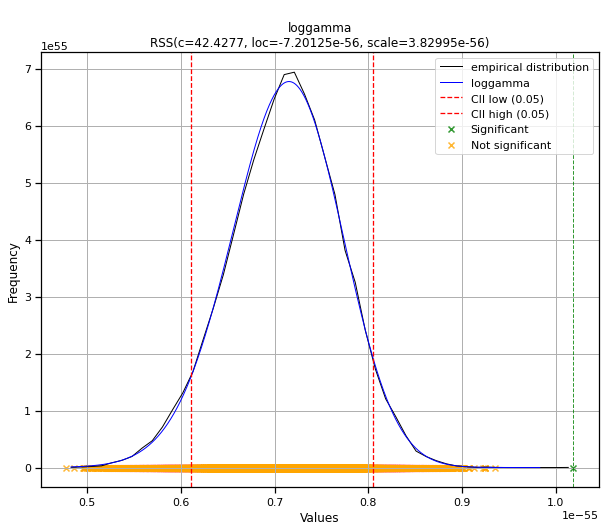

In [124]:
from distfit import distfit
dist = distfit()
dist.fit_transform(area_i)
f1 = dist.predict(area_i)
dist.plot()

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 1.96209e+109] [loc=0.000 scale=0.000]
[distfit] >[expon     ] [0.00 sec] [RSS: 1.52938e+111] [loc=0.000 scale=0.000]
[distfit] >[pareto    ] [0.00 sec] [RSS: inf] [loc=-0.000 scale=0.000]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 7.25406e+109] [loc=0.000 scale=0.000]
[distfit] >[t         ] [0.33 sec] [RSS: 2.6148e+111] [loc=-0.000 scale=0.000]
[distfit] >[genextreme] [0.19 sec] [RSS: 2.6148e+111] [loc=0.000 scale=0.000]
[distfit] >[gamma     ] [0.06 sec] [RSS: 3.33158e+109] [loc=0.000 scale=0.000]
[distfit] >[lognorm   ] [0.18 sec] [RSS: 2.61445e+111] [loc=-0.000 scale=0.000]
[distfit] >[beta      ] [0.24 sec] [RSS: 3.43402e+109] [loc=0.000 scale=0.000]
[distfit] >[uniform   ] [0.00 sec] [RSS: 1.48296e+111] [loc=0.000 scale=0.000]
[distfit] >[loggamma  ] [0.09 sec] [RSS: 2.35726e+109] [loc=-0.000 scale=0.000]
[distfit] >Compute confidence interval [parametric]
[distfit] >predict..
[distfit] >Multiple test 

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nnorm\nRSS(loc=1.53765e-55, scale=2.66891e-56)'}, xlabel='Values', ylabel='Frequency'>)

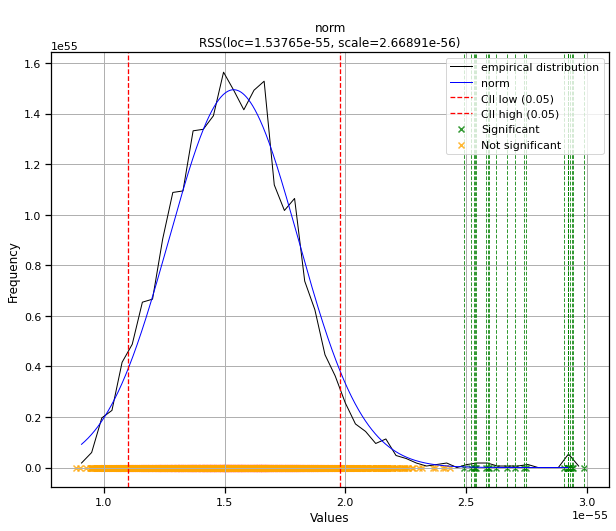

In [125]:
dist1 = distfit()
dist1.fit_transform(area_f)
f2 = dist1.predict(area_f)
dist1.plot()

In [117]:
#f1y = f1['y_proba']
#f2y = f2['y_proba']
#f1x = f1['y']
#f2x = f2['y']

In [118]:
#f_z = sig.oaconvolve(f2y,f1y)

In [119]:
#plt.plot(f_z)
#plt.show()

In [120]:
#plt.scatter(f1x,f1y)
#plt.show()

In [121]:
#plt.scatter(f2x,f2y)
#plt.show()

# Gaussian KDE

In [180]:
ker_i = scipy.stats.gaussian_kde(area_i)
ker_f = scipy.stats.gaussian_kde(area_f)

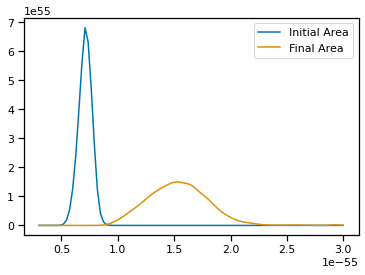

In [185]:
start = 0.3*1e-55
finish = 3*1e-55 
u = np.linspace(start,finish,100)
v = ker_i.evaluate(u)
w = ker_f.evaluate(u)
plt.plot(u,v,label = 'Initial Area')
plt.plot(u,w,label = 'Final Area')
plt.legend()
plt.show()